Импорт библиотек Python

In [1]:
import numpy as np
import sklearn
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D
from scipy import stats
from PIL import Image
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn import linear_model
from sklearn.preprocessing import PolynomialFeatures
import scipy.stats as stats
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
import math
import pylab 
from sklearn.linear_model import  LassoLarsIC

Загрузка файла, отображение датафрейма

In [ ]:
lunar = pd.read_table('lunar_finale.csv', na_values='NA', delimiter=',')
lunar.head(5)

*   Категориальные переменные: Eclipse type; Lunation Number; Saros Number; Quincena Solar Eclipse; Latitude3; Longitude3
* Непрерывные: остальные


*   Отбираю переменные для лабораторной работы
  *   Непрерывные: gamma (V1); penumbral magnitude (V2); penumbral eclipse duration (m) (V3);
  *   Дискретные: Quincena Solar Eclipse (V4); latitude3 (V5); longitude3 (V6); 
  *   Целевая переменная: Total Eclipse Duration (m) (V7);



In [ ]:
X=lunar[['Gamma','Penumbral Magnitude', 'Penumbral Eclipse Duration (m)', 'Quincena Solar Eclipse', 'Latitude3', 'Longitude3']]
y=lunar['Total Eclipse Duration (m)']
X.columns = ["V"+str(i) for i in range(1, len(X.columns)+1)]
data=X
data['V7']=pd.Series(y)
data.head()

Непараметрическая оценка функция плотности распределния случайных величин в виде гистограм и kde

In [ ]:
plt.figure(figsize=(50, 50))
pd.plotting.scatter_matrix(data.loc[:, "V1":"V6"], diagonal="kde")
plt.tight_layout()
plt.show()
pd.plotting.scatter_matrix(data.loc[:, "V1":"V6"], diagonal="hist")
plt.tight_layout()
plt.show()


Оценка вектора математического ожидания, диагональных элементов матрицы ковариации и самой матрицы ковариации

In [6]:
MEAN=X.apply(np.mean)
STD=X.apply(np.std)
MX=[]
DX=[]
for i in range(len(MEAN)-1):
  MX.append(MEAN[i])
  DX.append(STD[i]**2)
print('Mathematical expactation =',MX)
print('Variance =',DX)

Mathematical expactation = [0.0024900116047745385, 1.4186558189655185, 269.9719413129976, 4.05487400530504, -0.32020888594164454, 0.1443136604774536]
Variance = [0.828951005897408, 0.692604433381257, 6390.7442002764055, 8.951398657864244, 276.1470518131455, 10809.595469986423]


In [7]:
R=X.cov()
R.loc["V1":"V6", "V1":"V6"]

,V1,V2,V3,V4,V5,V6
V1,0.829020,-0.003915,-0.613209,-0.001145,0.879921,-0.026467
V2,-0.003915,0.692662,60.177305,0.559176,0.011346,-0.179882
V3,-0.613209,60.177305,6391.273981,54.707948,10.047825,-17.589203
V4,-0.001145,0.559176,54.707948,8.952141,-3.633924,2.993241
V5,0.879921,0.011346,10.047825,-3.633924,276.169944,-8.720179
V6,-0.026467,-0.179882,-17.589203,2.993241,-8.720179,10810.491565


Непараметрические оценки условных распределений + условные мат.ожидания и условные ковариации (относительно переменной V7//10)

In [ ]:
X['V7//10']=X.V7//10

In [ ]:
cond_MX=[]
cond_std=[]
for el in X['V7//10'].unique():
  class2data= X[X['V7//10']==el]
  cond_MX.append(class2data.loc[:,['V1','V2','V3','V4','V5','V6']].apply(np.mean))
  cond_std.append(class2data.loc[:,['V1','V2','V3','V4','V5','V6']].apply(np.std))
print(cond_MX)
print(cond_std)
print(X['V7//10'].unique())

In [ ]:
for col in X.columns:
  if (col!="V7" and col!='V7//10'):
    sns.displot(X, x=col, hue="V7//10", kind="kde", fill=True)

Оценка парных коэффициентов корреляции, доверительных интервалов для них и уровней значимости

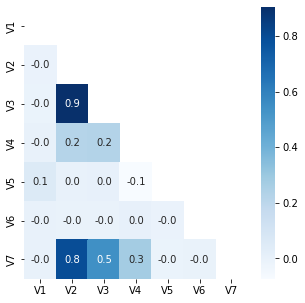

In [21]:
X_predictors=X.drop(['V7//10'], axis=1)
mask = np.zeros_like(X_predictors.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(X_predictors.corr(), mask = mask, annot=True, fmt= '.1f', ax = ax, cmap = 'Blues')

In [ ]:
for icol in X_predictors.columns:
  for jcol in X_predictors.columns:
    if (icol<jcol):
      x = X[icol].apply(lambda x: float(x))
      y = X[jcol].apply(lambda x: float(x))
      r, p = stats.pearsonr(x,y)
      r_z = np.arctanh(r)
      se = 1/np.sqrt(x.size-3)
      alpha = 0.05
      z = stats.norm.ppf(1-alpha/2)
      lo_z, hi_z = r_z-z*se, r_z+z*se
      print((icol,jcol,r,p,(lo_z,hi_z)))


*   Задача регрессии: предсказать суммарную длительность лунных затмений на основе имеющихся данных
*   Ищем множественный коэффициент корреляции суммарной длительности затмения и других переменных



In [23]:
R=X_predictors.corr()
Alg=R.drop('V7', axis=0)
Alg=Alg.drop('V7',axis=1)
deter=np.linalg.det(R)
comp=np.linalg.det(Alg)
R0=np.sqrt(1-deter/comp)
print(R0)

0.9018378147954862


Без нормализации; линейная регрессия

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X_predictors.drop(['V7'],axis=1), y, test_size=0.33, random_state=42)
x = []
for i in range(len(y_test)):
    x.append(i)

reg = LinearRegression(normalize=True)
reg.fit(X_train, y_train)

y_pred = reg.predict(X_test)
params = np.append(reg.intercept_,reg.coef_)

In [27]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
mape = mean_absolute_percentage_error(y_test, y_pred)
r2 = sklearn.metrics.r2_score(y_test,y_pred)
print('Mean absolute percentage error = ', mape)
print('Mean absolute error = ', mae)
print('Mean squared error = ', mse)
print('R2 = ', r2)

Mean absolute percentage error =  inf
Mean absolute error =  13.604762914180375
Mean squared error =  282.15912610409436
R2 =  0.8079817800903051


Text(0, 0.5, 'Total eclipse duration')

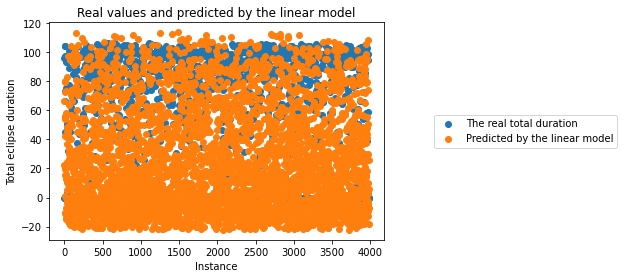

In [28]:
plt.scatter(x, y_test, label = u'The real total duration')
plt.scatter(x, y_pred, label = u'Predicted by the linear model')
plt.title(u'Real values and predicted by the linear model')
plt.legend(loc="center right",borderaxespad=0.1, bbox_to_anchor=(1.7, 0.5))
plt.xlabel(u'Instance')
plt.ylabel(u'Total eclipse duration')

Полиномиальная модель

In [63]:
poly = PolynomialFeatures(6)
X_train_new = poly.fit_transform(X_train)
poly = PolynomialFeatures(6)
X_test_new = poly.fit_transform(X_test)
reg = LinearRegression(normalize=True)
reg.fit(X_train_new, y_train)
y_pred_poly = reg.predict(X_test_new)
X_new = poly.fit_transform(X)

In [40]:
r2=sklearn.metrics.r2_score(y_test,y_pred_poly)
print('R2 = ', r2)
mae = mean_absolute_error(y_test, y_pred_poly)
mse = mean_squared_error(y_test, y_pred_poly)
print('Mean absolute error = ', mae)
print('Mean squared error = ', mse)
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
mape = mean_absolute_percentage_error(y_test, y_pred_poly)
print('Mean absolute percentage error = ', mape)

R2 =  0.9879793754636161
Mean absolute error =  2.646067286504068
Mean squared error =  17.663578570859578
Mean absolute percentage error =  inf


Text(0, 0.5, 'Total eclipse duration')

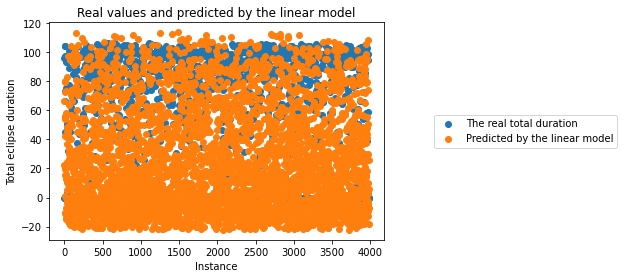

In [41]:
plt.scatter(x, y_test, label = u'The real total duration')
plt.scatter(x, y_pred, label = u'Predicted by the linear model')
plt.title(u'Real values and predicted by the linear model')
plt.legend(loc="center right",borderaxespad=0.1, bbox_to_anchor=(1.7, 0.5))
plt.xlabel(u'Instance')
plt.ylabel(u'Total eclipse duration')

С нормализацией

In [59]:
X_norm=X_predictors
X_norm=sklearn.preprocessing.scale(X_norm, axis=0, with_mean=True, with_std=True)
X_norm=pd.DataFrame(X_norm)
X_norm.columns = ["V"+str(i) for i in range(1, len(X_norm.columns)+1)]

In [60]:
x_norm=X_norm.drop(['V7'],axis=1)
y_norm=X_norm['V7']

In [61]:
X_train, X_test, y_train, y_test = train_test_split(x_norm, y_norm, test_size=0.33, random_state=42)
x = []
for i in range(len(y_test)):
    x.append(i)

reg = LinearRegression(normalize=True)
reg.fit(X_train, y_train)

y_pred = reg.predict(X_test)
params = np.append(reg.intercept_,reg.coef_)

In [46]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
mape = mean_absolute_percentage_error(y_test, y_pred)
r2 = sklearn.metrics.r2_score(y_test,y_pred)
print('Mean absolute percentage error = ', mape)
print('Mean absolute error = ', mae)
print('Mean squared error = ', mse)
print('R2 = ', r2)

Mean absolute percentage error =  54.255739809073376
Mean absolute error =  0.3526869999079509
Mean squared error =  0.18962301582229896
R2 =  0.8079817800903051


Регрессия с регуляризацией

In [57]:
from sklearn.linear_model import RidgeCV
X_train, X_test, y_train, y_test = train_test_split(X_predictors.drop(['V7'],axis=1), y, test_size=0.33, random_state=42)
clf = RidgeCV(alphas=[0.1, 1.0, 10.0]).fit(X_train, y_train)
y_pred=clf.predict(X_test)

In [58]:
print(clf.score(X_train, y_train))
print(clf.score(X_test,y_test))

0.8158588489810465
0.8079830826961745


In [50]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
mape = mean_absolute_percentage_error(y_test, y_pred)
r2 = sklearn.metrics.r2_score(y_test,y_pred)
print('Mean absolute percentage error = ', mape)
print('Mean absolute error = ', mae)
print('Mean squared error = ', mse)
print('R2 = ', r2)

Mean absolute percentage error =  inf
Mean absolute error =  13.604665684209301
Mean squared error =  282.15721200378704
R2 =  0.8079830826961744


Анализ главных компонент

In [68]:
X_pca=X

,V1,V2,V3,V4,V5,V6,V7,V7//10
count,12064.000000,12064.000000,12064.000000,12064.000000,12064.000000,12064.000000,12064.000000,12064.000000
mean,0.002490,1.418656,269.971941,4.054874,-0.320209,0.144314,23.307999,2.186091
std,0.910505,0.832263,79.945444,2.992013,16.618362,103.973514,38.576207,3.646136
min,-1.582700,0.000400,5.200000,0.000000,-25.000000,-180.000000,0.000000,0.000000
25%,-0.788825,0.684425,223.100000,2.000000,-17.000000,-90.000000,0.000000,0.000000
50%,0.001750,1.417450,295.000000,4.000000,-1.000000,0.000000,0.000000,0.000000
75%,0.791725,2.136900,327.800000,7.000000,16.000000,90.000000,51.600000,5.000000
max,1.579100,2.908900,379.500000,10.000000,25.000000,180.000000,106.600000,10.000000


In [ ]:
scaler=StandardScaler()
scaler.fit(X_pca)
X_pca=scaler.transform(X_pca)
X_pca

In [73]:
pca=PCA(n_components=6)
pca.fit(X_pca)
x_pca=pca.transform(X_pca)
x_pca.shape

(12064, 6)

Text(0, 0.5, 'Second comp')

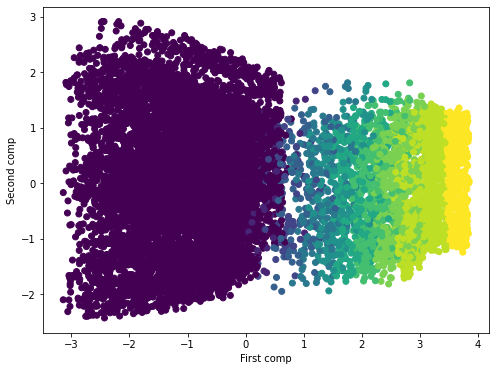

In [74]:
plt.figure(figsize=(8,6))
plt.scatter(x_pca[:,0],x_pca[:,1],c=X['V7//10'])
plt.xlabel('First comp')
plt.ylabel('Second comp')

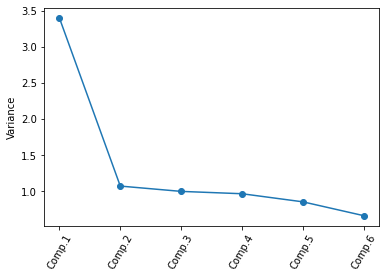

In [75]:
def screeplot(pca, standardised_values):
    y = np.std(pca.transform(standardised_values), axis=0)**2
    x = np.arange(len(y)) + 1
    plt.plot(x, y, "o-")
    plt.xticks(x, ["Comp."+str(i) for i in x], rotation=60)
    plt.ylabel("Variance")
    plt.show()
screeplot(pca, X_pca)

In [76]:
X_train, X_test, y_train, y_test = train_test_split(x_pca, y, test_size=0.33, random_state=42)
x = []
for i in range(len(y_test)):
    x.append(i)

reg = LinearRegression(normalize=True)
reg.fit(X_train, y_train)

y_pred = reg.predict(X_test)
params = np.append(reg.intercept_,reg.coef_)

In [77]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
mape = mean_absolute_percentage_error(y_test, y_pred)
r2 = sklearn.metrics.r2_score(y_test,y_pred)
print('Mean absolute percentage error = ', mape)
print('Mean absolute error = ', mae)
print('Mean squared error = ', mse)
print('R2 = ', r2)

Mean absolute percentage error =  inf
Mean absolute error =  1.1364872668608645
Mean squared error =  2.02362118948432
R2 =  0.9986228617023963


Text(0, 0.5, 'Total eclipse duration')

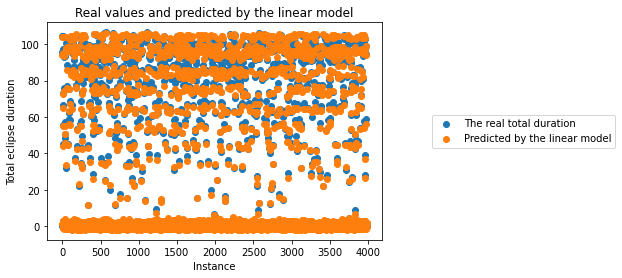

In [80]:
plt.scatter(x, y_test, label = u'The real total duration')
plt.scatter(x, y_pred, label = u'Predicted by the linear model')
plt.title(u'Real values and predicted by the linear model')
plt.legend(loc="center right",borderaxespad=0.1, bbox_to_anchor=(1.7, 0.5))
plt.xlabel(u'Instance')
plt.ylabel(u'Total eclipse duration')

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


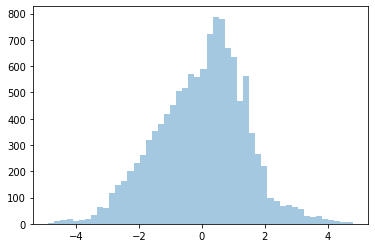

In [87]:
y1 = np.array(y)
y_pred_all = np.array(reg.predict(x_pca))
y2 = np.array(y_pred_all)
y_diff = y1[:] - y2[:]
sns.distplot(y_diff, kde=False)